Data [source](https://www.kaggle.com/c/rossmann-store-sales)

# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import inflection
import random
import pickle
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


from tabulate import tabulate
from matplotlib.gridspec import GridSpec
from scipy import stats
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Helper Functions

In [2]:
# cross validation function
def cross_validation(x_training, kfold, model_name, model, verbose=False):

  # create empty lists for metrics
  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed(range(1, kfold+1)):
    if verbose:
      print(f'\nkfold number: {k}')
    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


    # split training and validation datasets
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # model 
    m = model

    # fit
    m.fit(xtraining, ytraining)

    # predict
    yhat = m.predict(xvalidation)

    # performance
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    # store performance of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                       'MAE CV': str(np.round(np.mean(mae_list), 2)) + ' +/- ' + str(np.round(np.std(mae_list), 2)),
                       'MAPE CV': str(np.round(np.mean(mape_list), 2)) + ' +/- ' + str(np.round(np.std(mape_list), 2)),
                       'RMSE CV': str(np.round(np.mean(rmse_list), 2)) + ' +/- ' + str(np.round(np.std(rmse_list), 2))}, index=[0])




def mean_percentage_error(y, y_hat):
    return np.mean((y - y_hat) / y)




def ml_error(model_name, y, y_hat):
    # MAE
    mae = mean_absolute_error(y, y_hat)
    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y, y_hat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])




def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    
    k_corr = k - (k-1) ** 2/(n-1)
    r_corr = r - (r-1) ** 2/(n-1)
    

    return np.sqrt((chi2_corr/n ) / (min(k_corr-1, r_corr-1)))



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Load Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)


# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')



# Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Rename Columns

In [7]:
old_cols = ['Store',
            'DayOfWeek',
            'Date',
            'Sales',
            'Customers',
            'Open',
            'Promo',
            'StateHoliday',
            'SchoolHoliday',
            'StoreType',
            'Assortment',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'PromoInterval']

new_cols = list(map(lambda x: inflection.underscore(x), old_cols))

df1.columns = new_cols

## Data Dimensions

In [8]:
print(f"Number of rows: {df1.shape[0]}")
print(f"Number of columns: {df1.shape[1]}")

Number of rows: 1017209
Number of columns: 18


## Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'] .apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                            0 if x['promo_interval'] == 0 else
                                                            1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attributes

In [19]:
cat_attributes.describe()

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,4,12
top,0,a,a,0,Mar
freq,986159,551627,537445,508031,103695


<AxesSubplot:xlabel='assortment', ylabel='sales'>

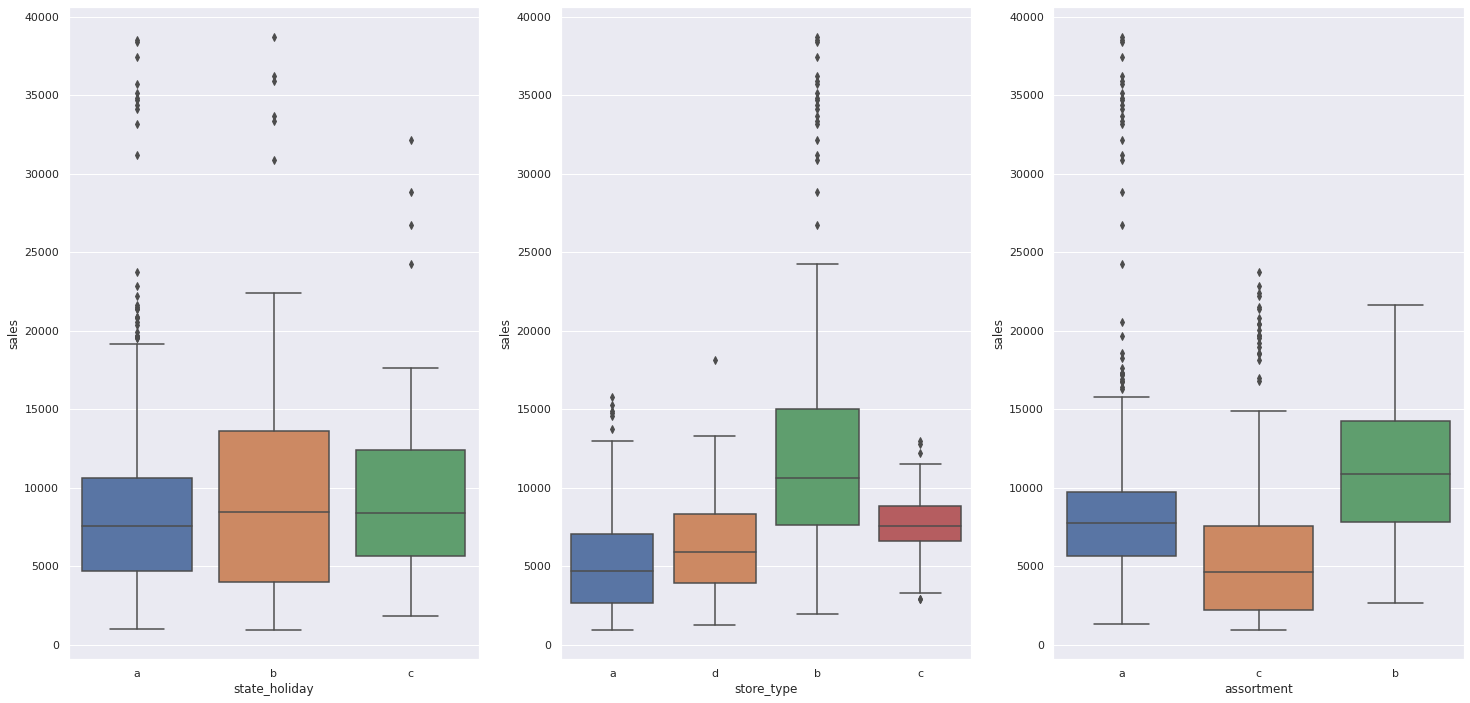

In [20]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]


ax1=plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1, ax=ax1)

ax2=plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y='sales', data=aux1, ax=ax2)

ax3=plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1, ax=ax3)

# Feature Engineering

In [21]:
df2 = df1.copy()

## Hypothesis Creation

### Hypothesis related to **Store**

1. Stores with more employees should sell more

2. Stores with greater inventory capacity should sell more

3. Larger stores should sell more

4. Stores with a larger assortment should sell more

5. Stores with closer competitors should sell less

6. Stores with longer-term competitors should sell more

### Hypothesis related to **Product**

1. Stores that invest more in Marketing should sell more

2. Stores with greater product exposure should sell more

3. Stores with products at a lower price should sell more

4. Stores with more aggressive promotions (bigger discounts) should sell more

5. Stores with promotions active for longer should sell more

6. Stores with more promotion days should sell more

7. Stores with more consecutive promotions should sell more

### Hypothesis related to **Temporality**

1. Stores open during the Christmas holiday should sell more

2. Stores should sell more over the years

3. Stores should sell more in the second half of the year

4. Stores should sell more after the 10th of each month

5. Stores should sell less on weekends

6. Stores should sell less during holidays

## Final Hypothesis List

(based if we have or not the hypothesis data into the dataset)

1. Stores with a larger assortment should sell more

2. Stores with closer competitors should sell less

3. Stores with longer-term competitors should sell more

4. Stores with promotions active for longer should sell more

5. Stores with more promotion days should sell more

6. Stores with more consecutive promotions should sell more

7. Stores open during the Christmas holiday should sell more

8. Stores should sell more over the years

9. Stores should sell more in the second half of the year

10. Stores should sell more after the 10th of each month

11. Stores should sell less on weekends

12. Stores should sell less during holidays

## Feature Engineering

In [22]:
# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# year
df2['year'] = df2['date'].dt.year

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                            'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                 'easter_holiday' if x == 'b' else
                                                 'christmas' if x == 'c' else 'regular_day')

# Variable Filtering

In [23]:
df3 = df2.copy()

## Rows Filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Columns Selection


In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# Exploratory Data Analysis (EDA)

In [26]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

/home/menon/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


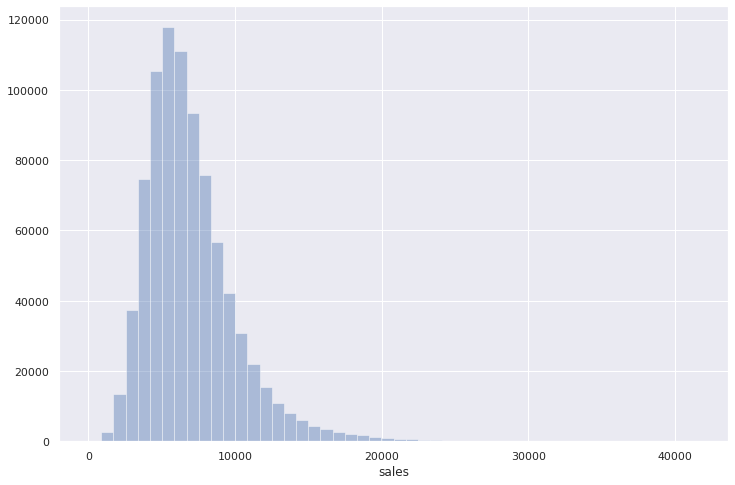

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(df4['sales'], kde=False)

### Numerical Variables

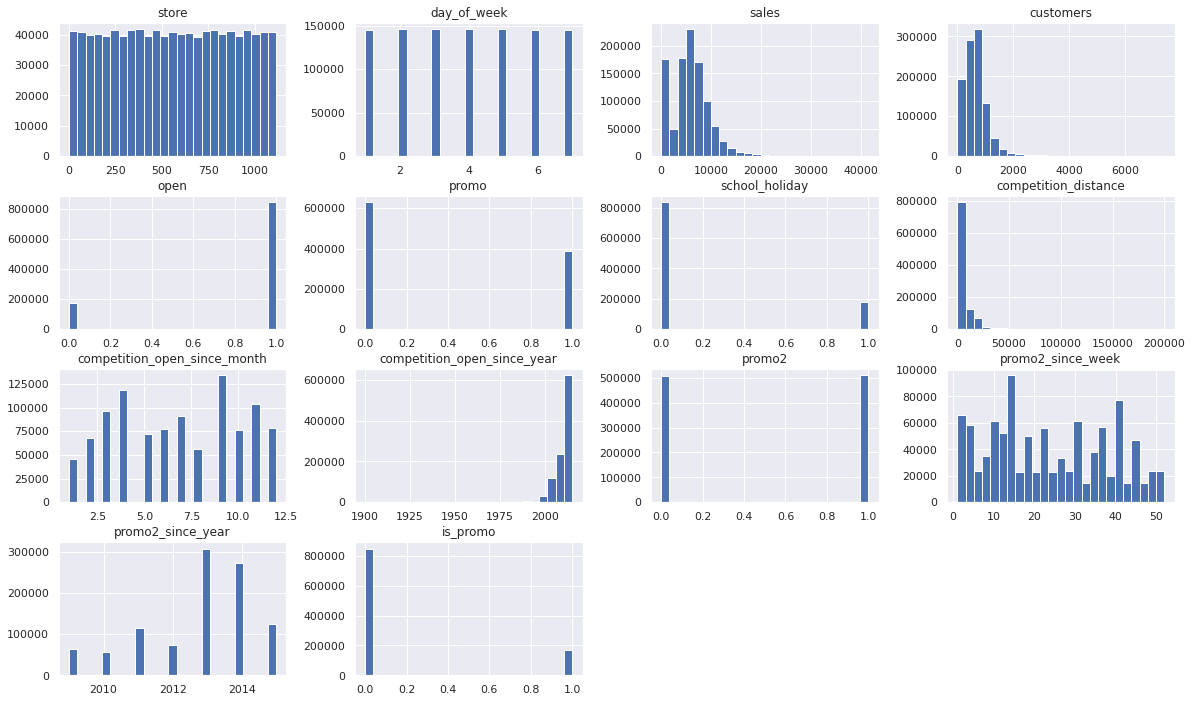

In [28]:
sns.set(rc={'figure.figsize':(20,12)})

num_attributes.hist(bins=25)
plt.show()

### Categorical Variable

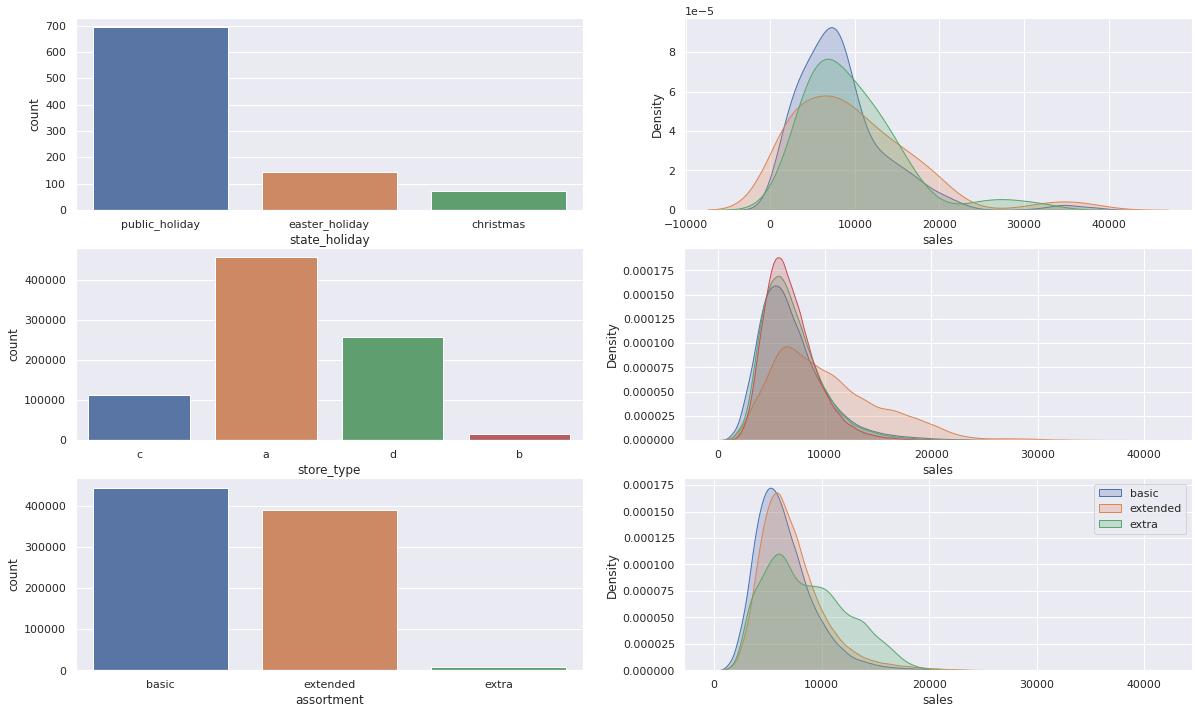

In [29]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


plt.legend()
plt.show()


## Bivariate Analysis

### H1: Stores with a larger assortment should sell more

**FALSE**: Stores with larger assortment sell less.

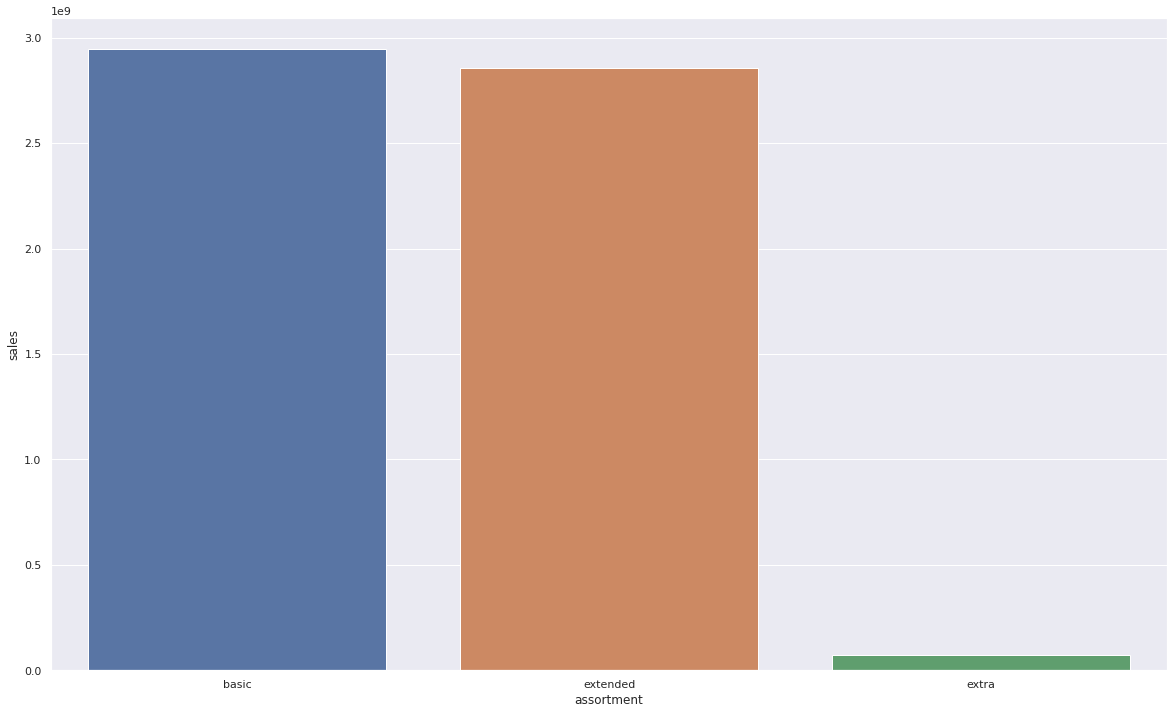

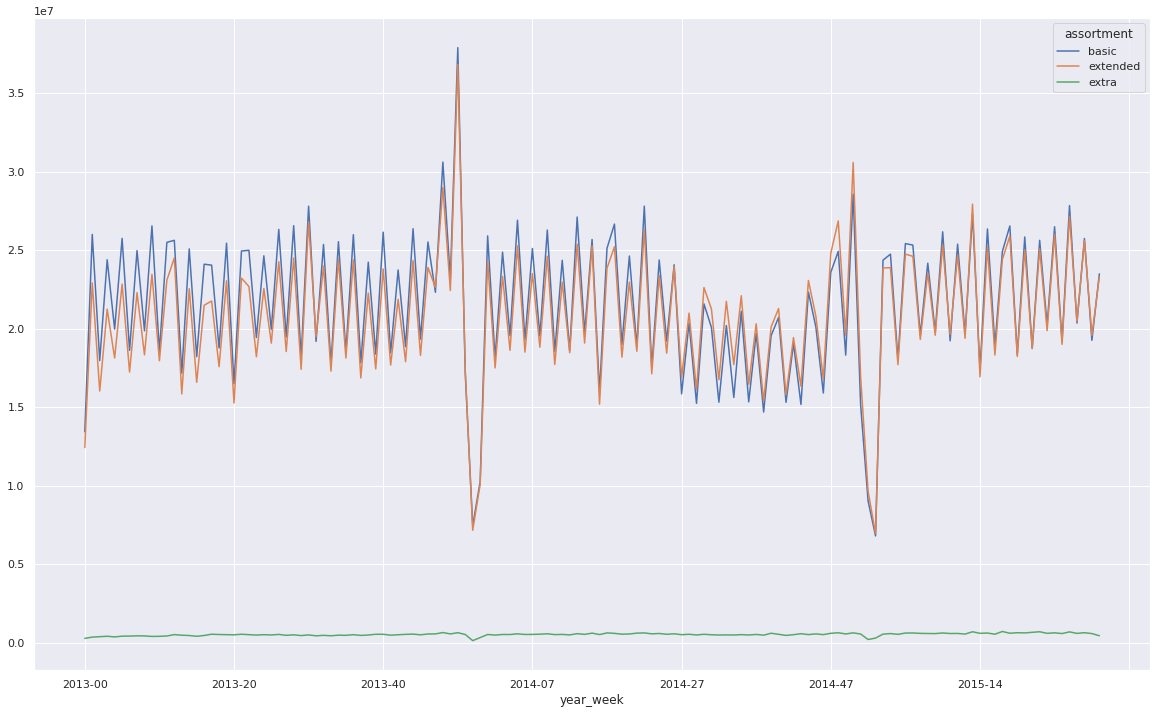

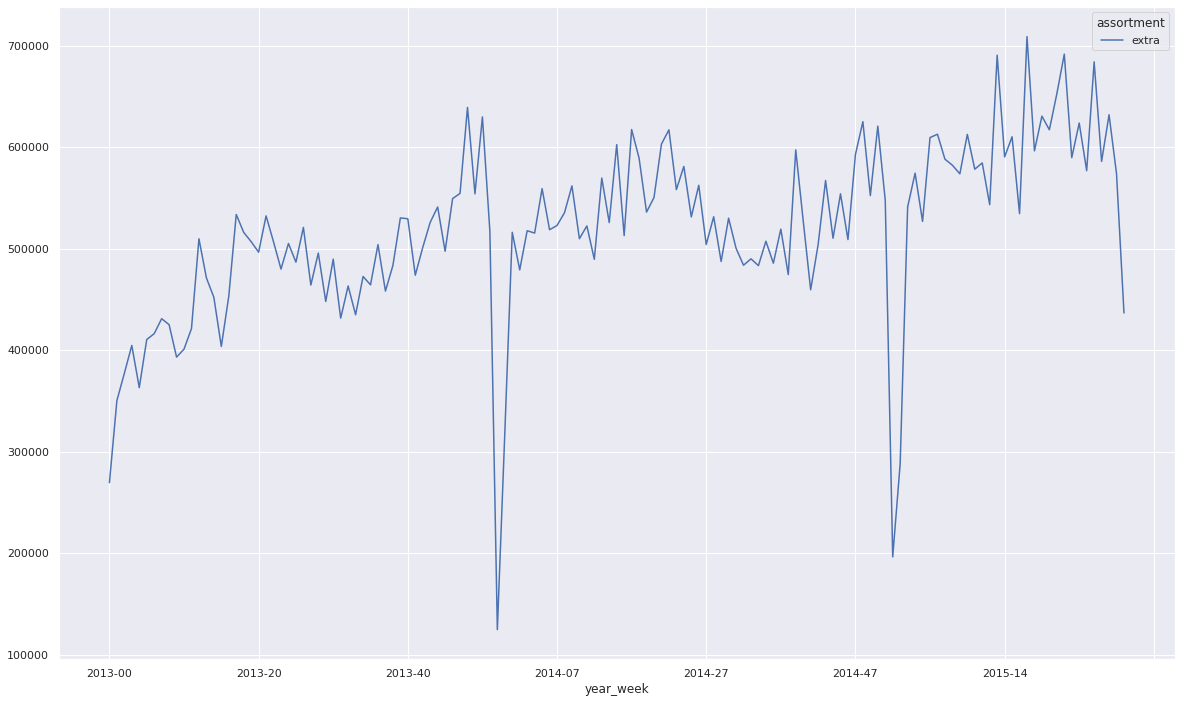

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

plt.show()

**Relevance**: This variable could be relevant for the model since although "basic" and "extended" are similar, the "extra" assortment is clearly different

### H2. Stores with closer competitors should sell less


**FALSE**: Stores with closer competitors sell more

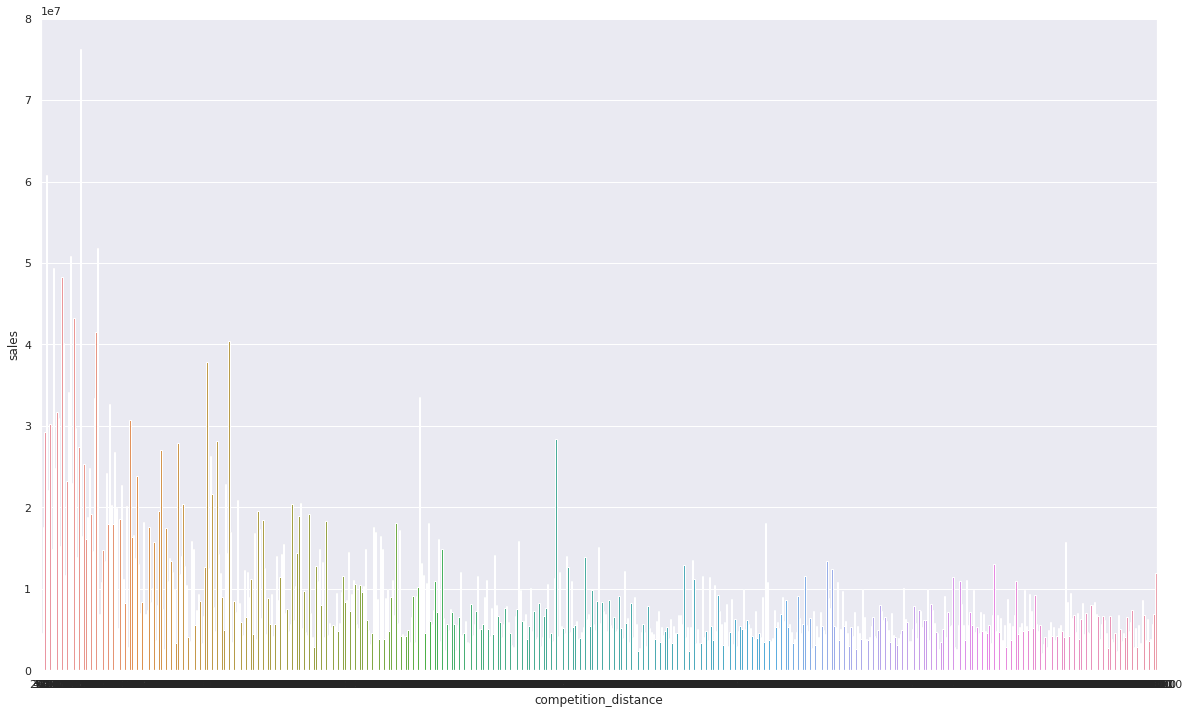

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance', y='sales', data=aux1)

plt.show()

Since this graph is much granular and we can't extract any information, make sense aggregate the values into bins 

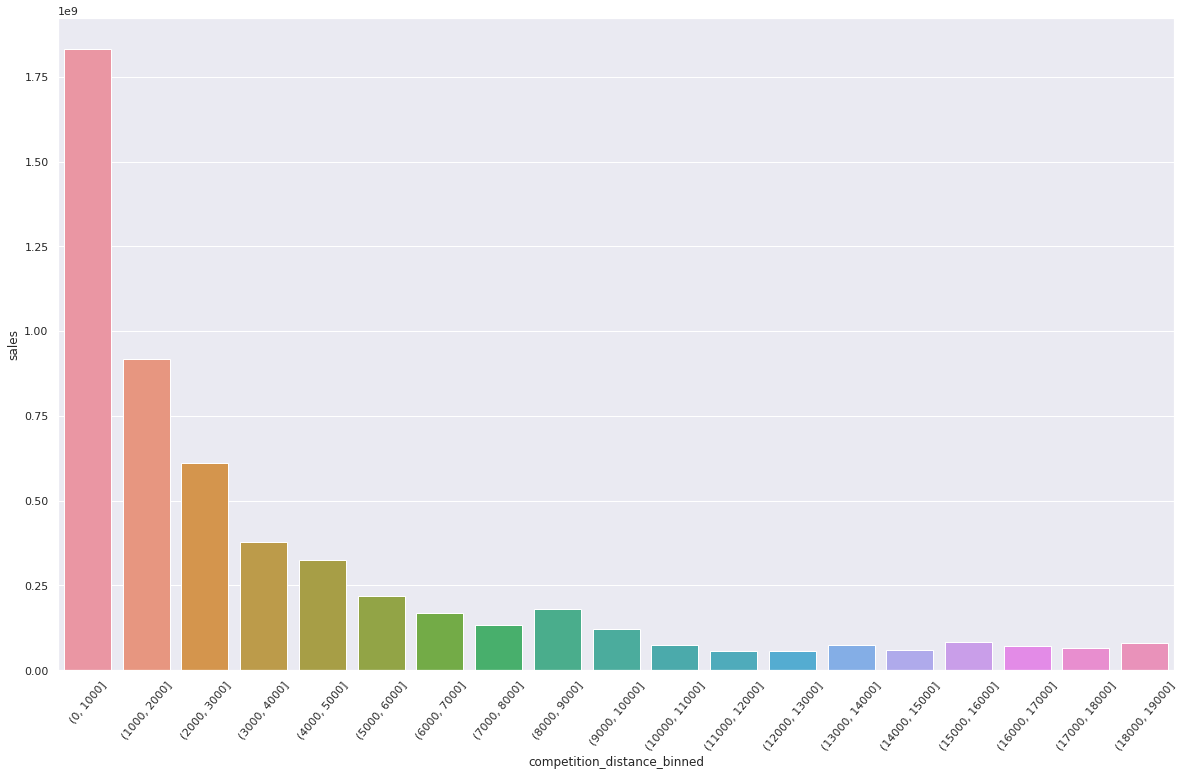

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# create bins
bins = list(np.arange(0, 20000, 1000)) # 20000 is the max value of the "competition_distance" column

# create new column competition_distance_binned
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

# create new dataframe with the new colum
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# plot
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=50)
plt.show()

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

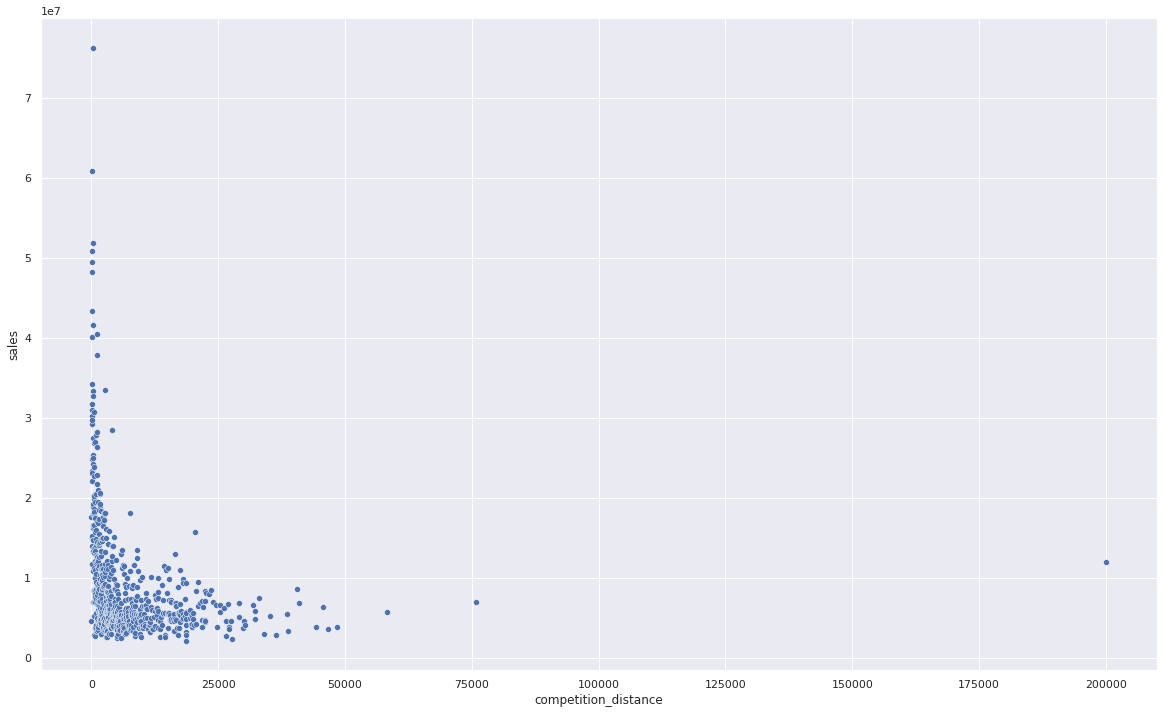

In [33]:
# to show the scatter of the variable
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

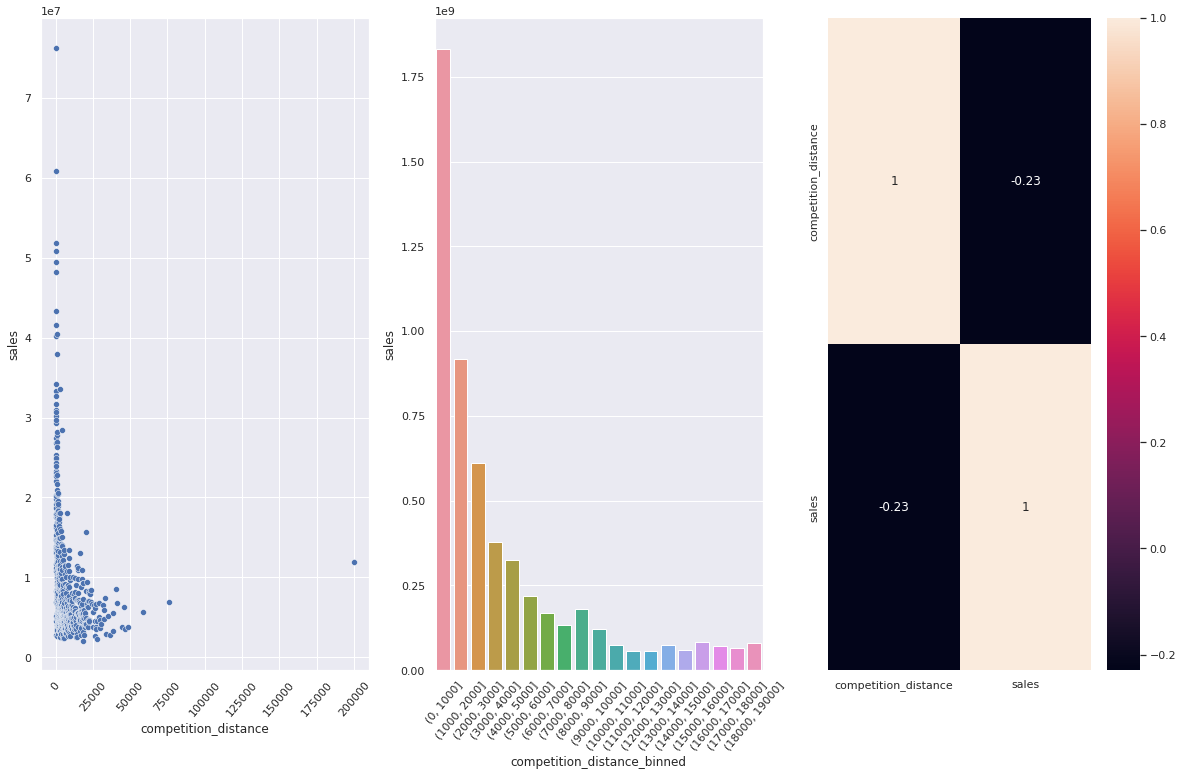

In [34]:
# now to resume this variable analysis in one snippet
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# plot scatterplot
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.xticks(rotation=50)

# plot barplot
plt.subplot(1, 3, 2)
# create bins
bins = list(np.arange(0, 20000, 1000)) # 20000 is the max value of the "competition_distance" column
# create new column competition_distance_binned
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# create new dataframe with the new colum
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=50)


#plot heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True  )

plt.show()

**Relevance**: This variable has low negative correlation with the target variable

### H3. Stores with longer-term competitors should sell more

**FALSE**: Stores with linger-term competitors sell less 

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

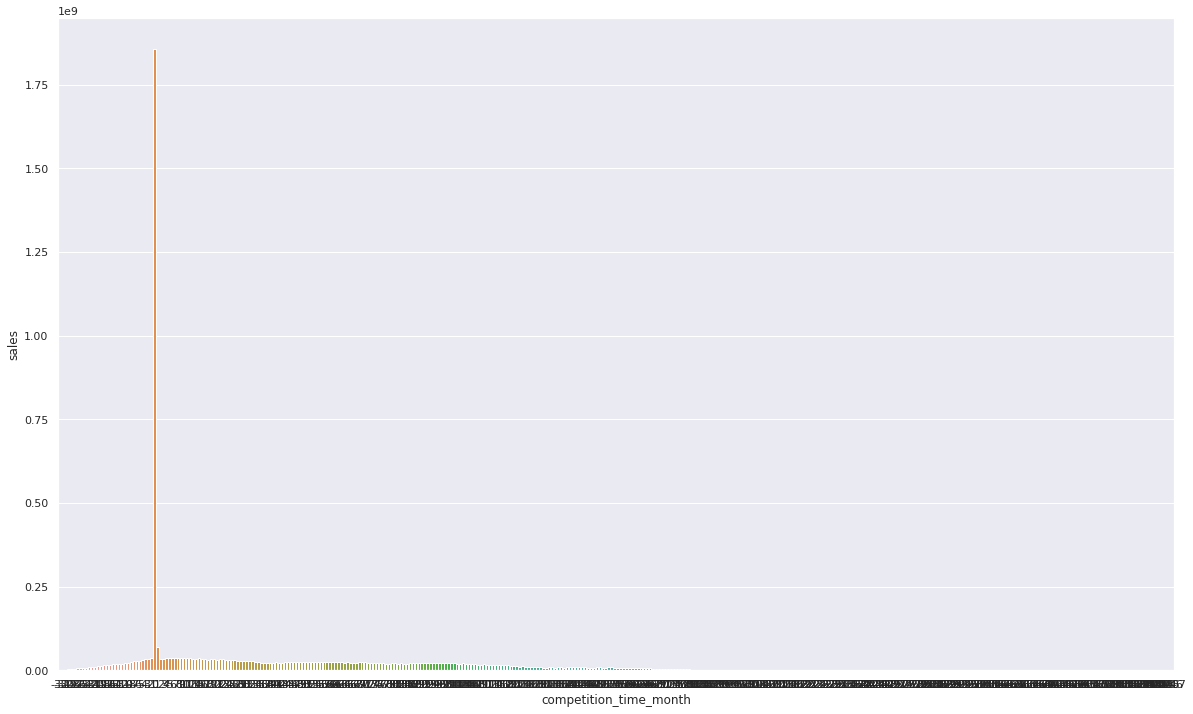

In [35]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
sns.barplot(x='competition_time_month', y='sales', data=aux1)

This graph is much granular, so we have to aggregate the values

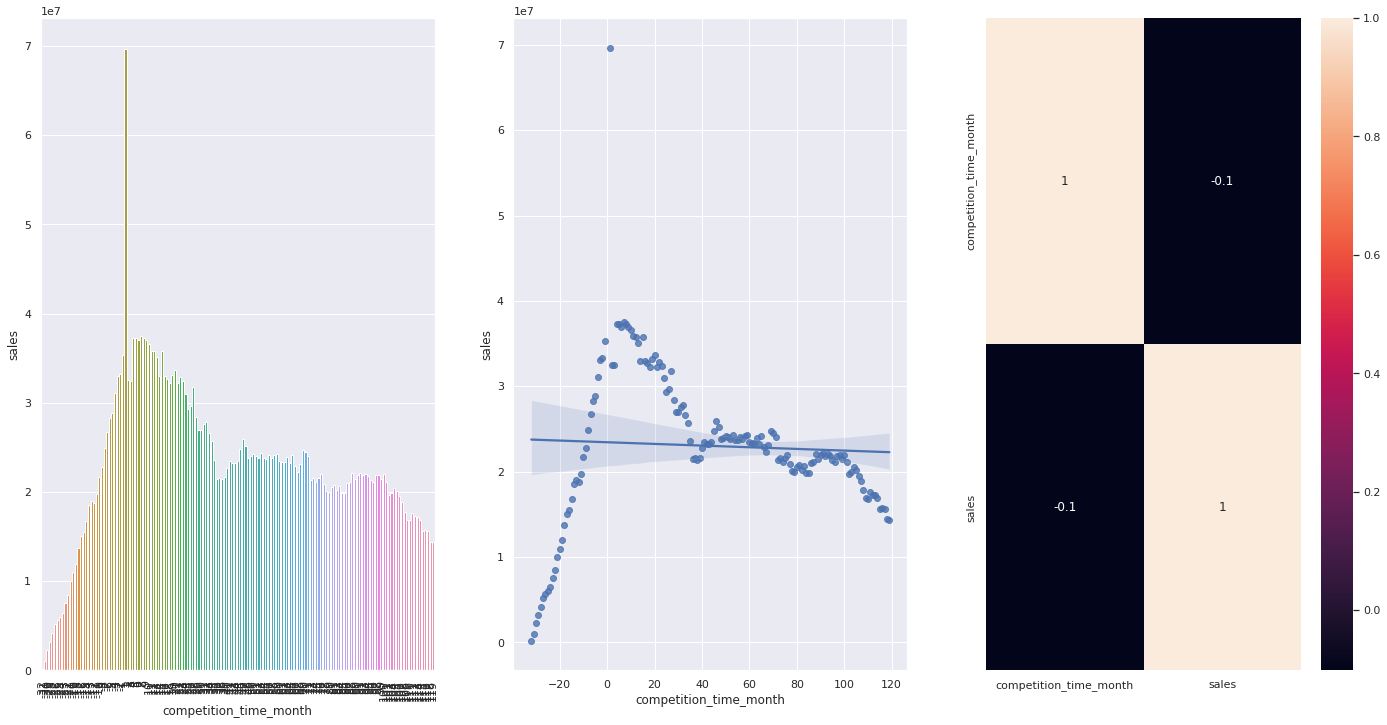

In [36]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# select competitiors with less than 120 months and grater than 0
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)] 

plt.figure(figsize=(24,12))

# plot barplot
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

# plot regplot
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# plot heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


plt.show()

### H4. Stores with promotions active for longer should sell more

**FALSE**: Stores with active promotion for longer sell less after a certain promotion period

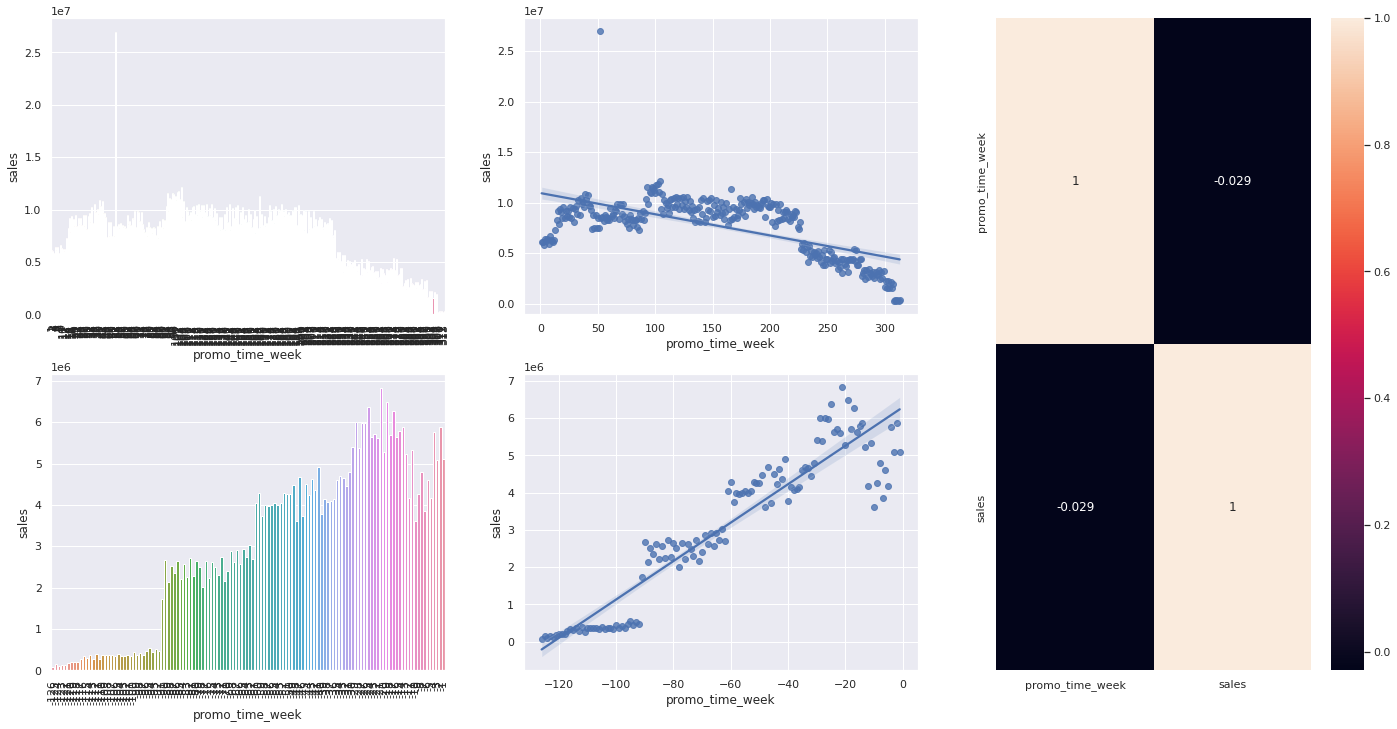

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)
plt.figure(figsize=(24,12))
# barplot
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotion
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

# regplot
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

# barplot
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

# regplot
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# heatmap
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


plt.show()

**Relevance:** The correlation between the target variable and "promo_time_week" is clearly weak (0.02)

### <s>H5. Stores with more promotion days should sell more </s>

### H6. Stores with more consecutive promotions should sell more

**FALSE**: Stores with more consecutive promotions sell less

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


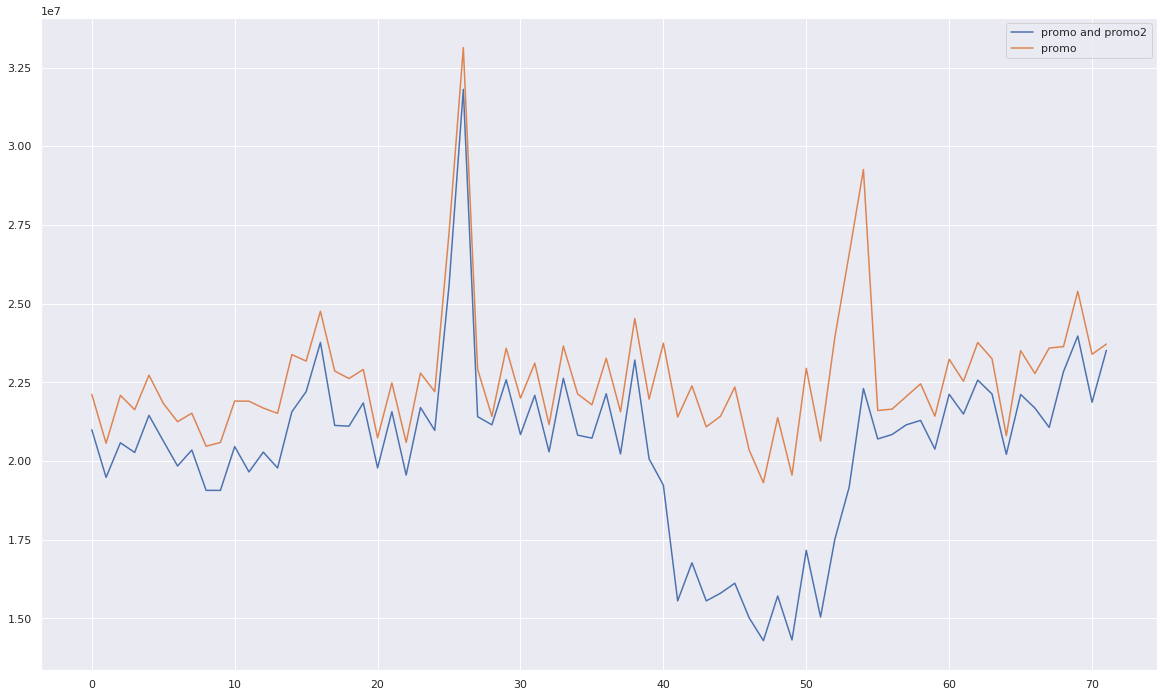

In [39]:
# stores that participated in the promo and promo2
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# stores that participated only in the promo2
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['promo and promo2', 'promo'])

plt.show()

**Relevance** This variable could not be relevant for the model since we have almost the same behavior for stores that participated only in "promo" or those who participated in "promo" and "promo2"

### H7. Stores open during the Christmas holiday should sell more

**FALSE**: Stores open during the Christmas holiday sell less

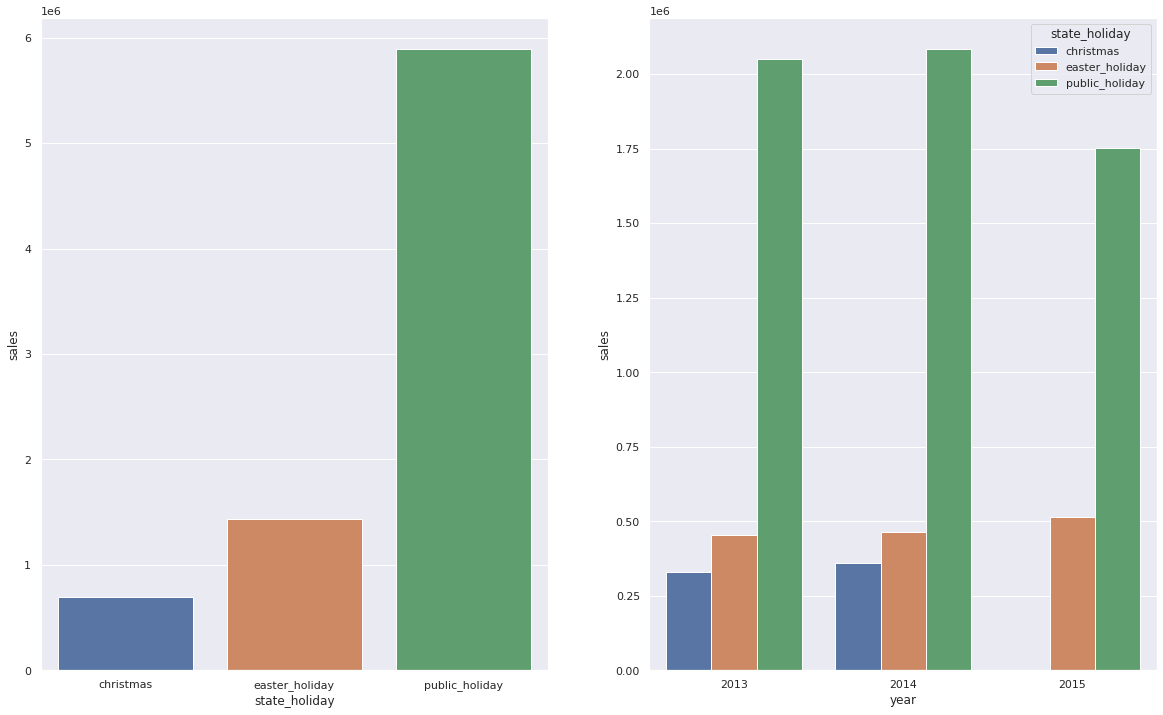

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']


# sales by state holiday
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

# sales by state holiday per year
plt.subplot(1, 2, 2)
aux2 = aux[['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',  data=aux2)

plt.show()

### H8. Stores should sell more over the years

**FALSE**: Stores sells less over the years

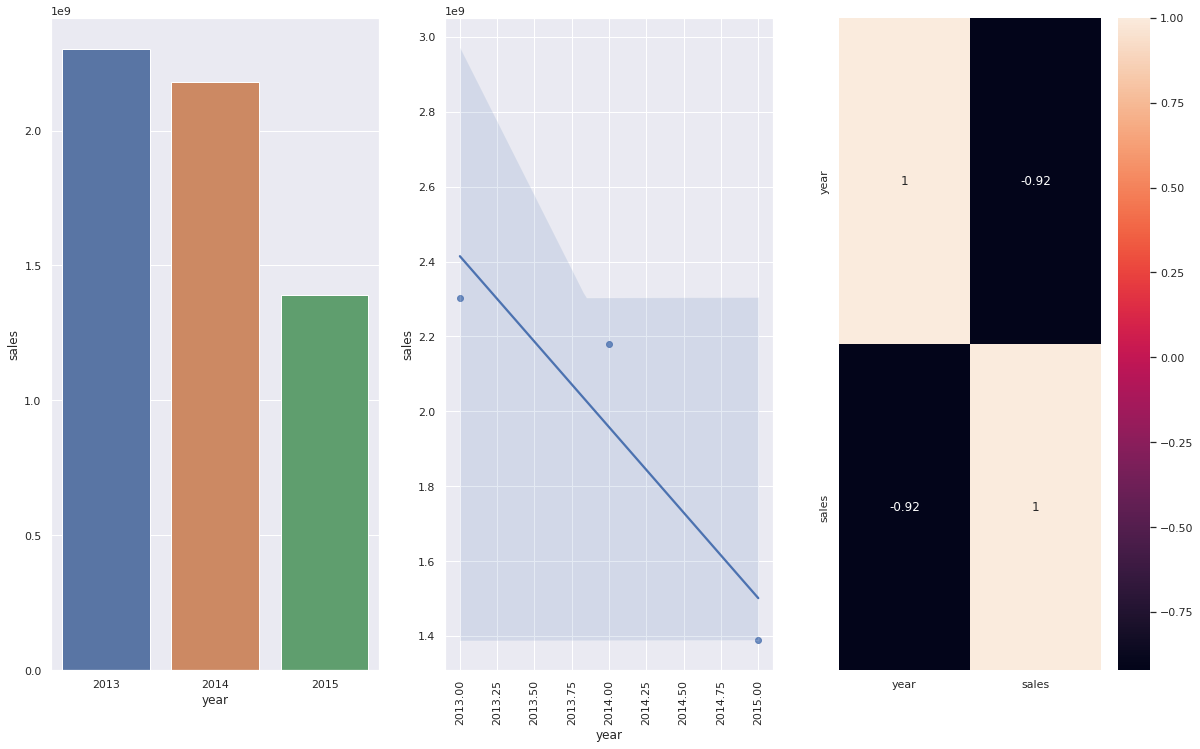

In [41]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


plt.show()

**Relevance**: Although the year 2015 is not "closed", we can see a clear trend of decreasing sales

### H9. Stores should sell more in the second half of the year

**FALSE**: Stores sell less in the second half of the year

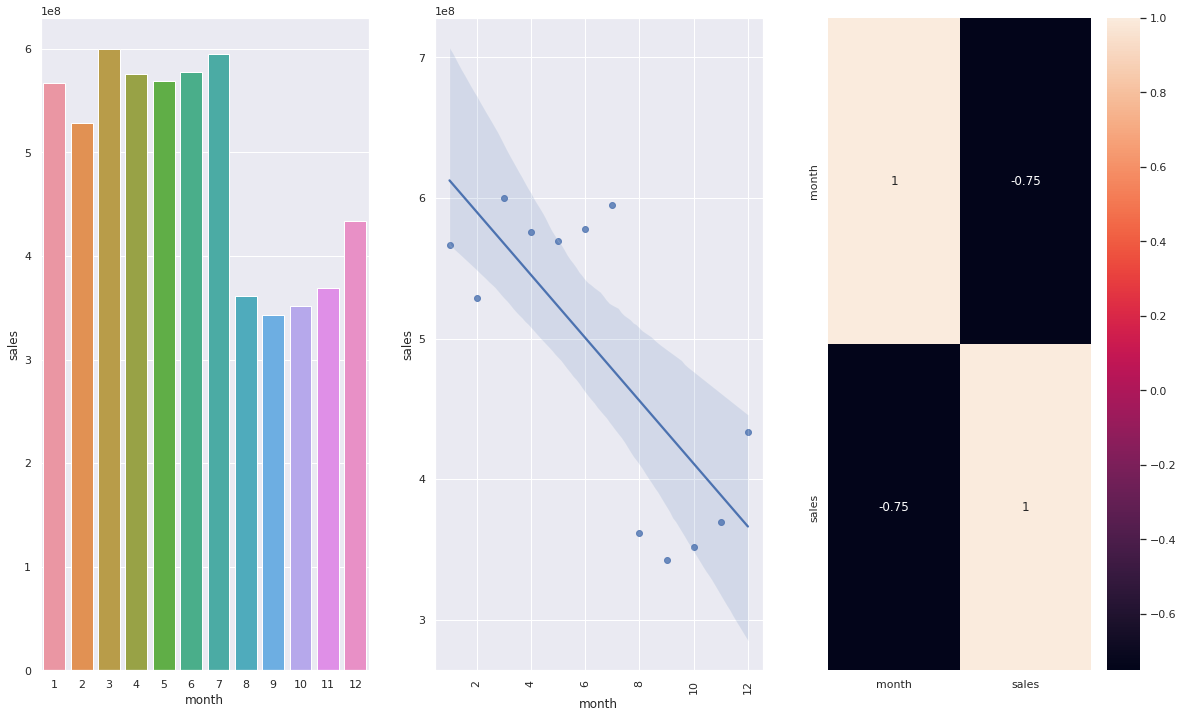

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


plt.show()

**Relevance**: This variable could be relevant to the model.

### H10. Stores should sell more after the 10th of each month

**TRUE**: Stores sell more after the 10th of each month

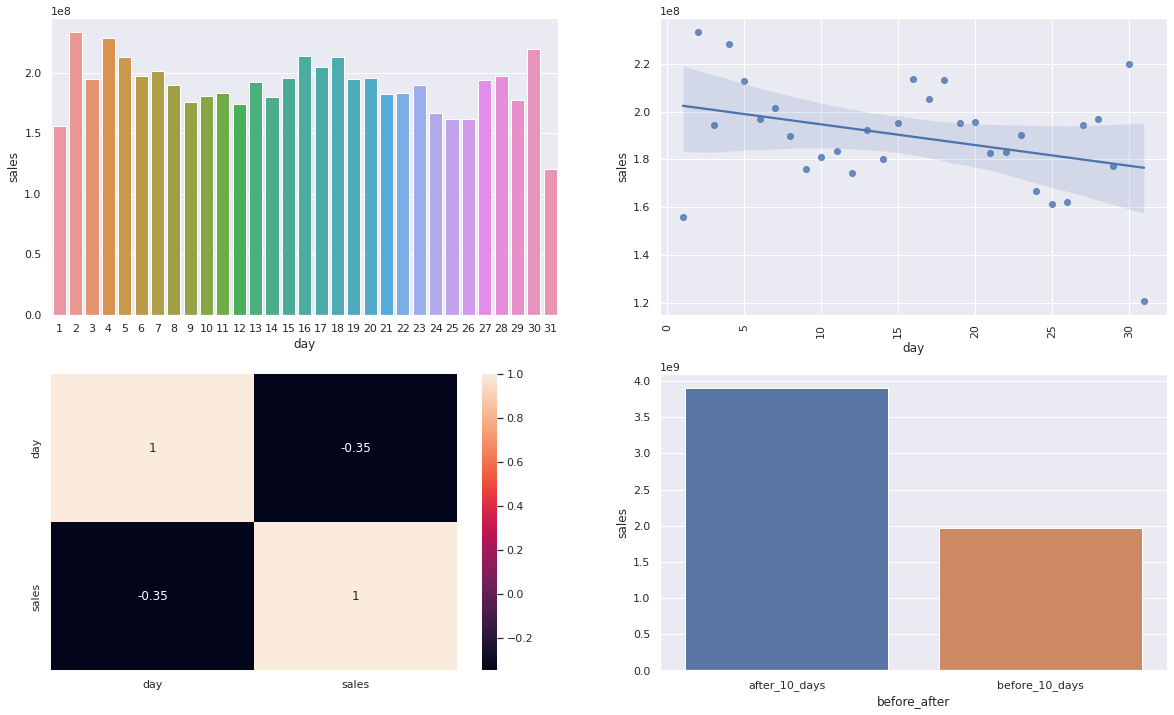

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

plt.show()

### H11. Stores should sell less on weekends

**TRUE**: Stores sell less on weekends

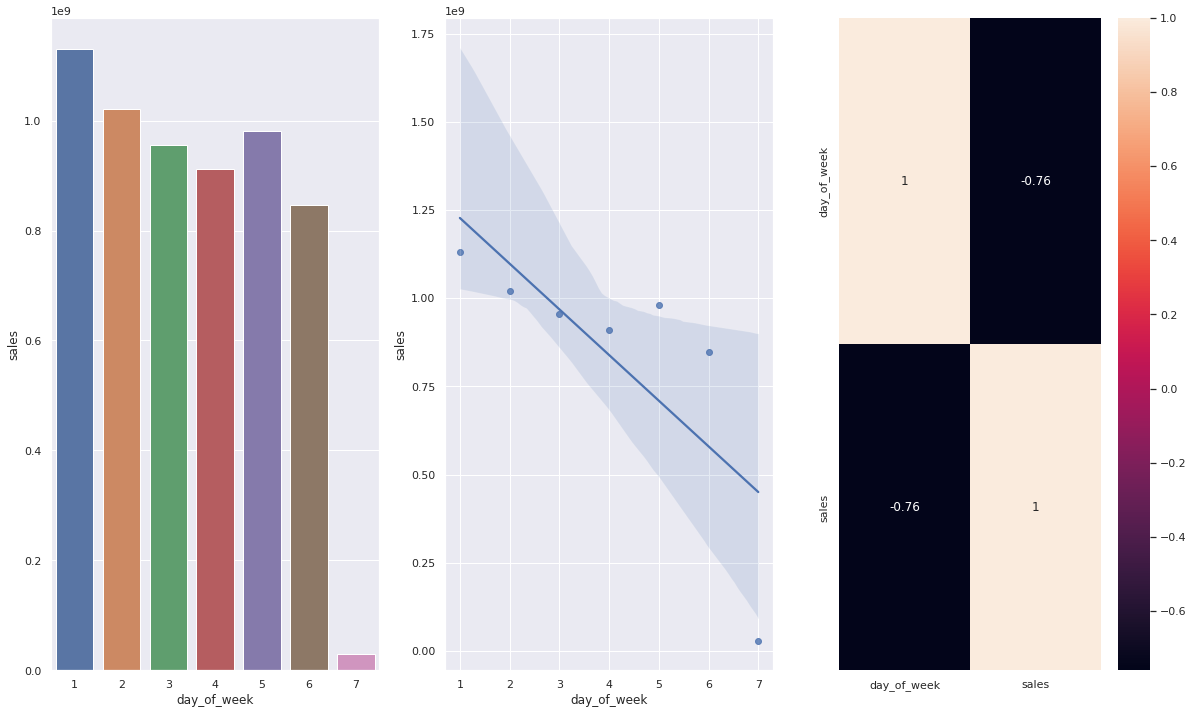

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


plt.show()

**Relevance**: Since it's correlation is -0.76, this could indicate that this variable will be relevant to the model 

### H12. Stores should sell less during school holidays

**TRUE** Stores sell less during school holidays except July and August

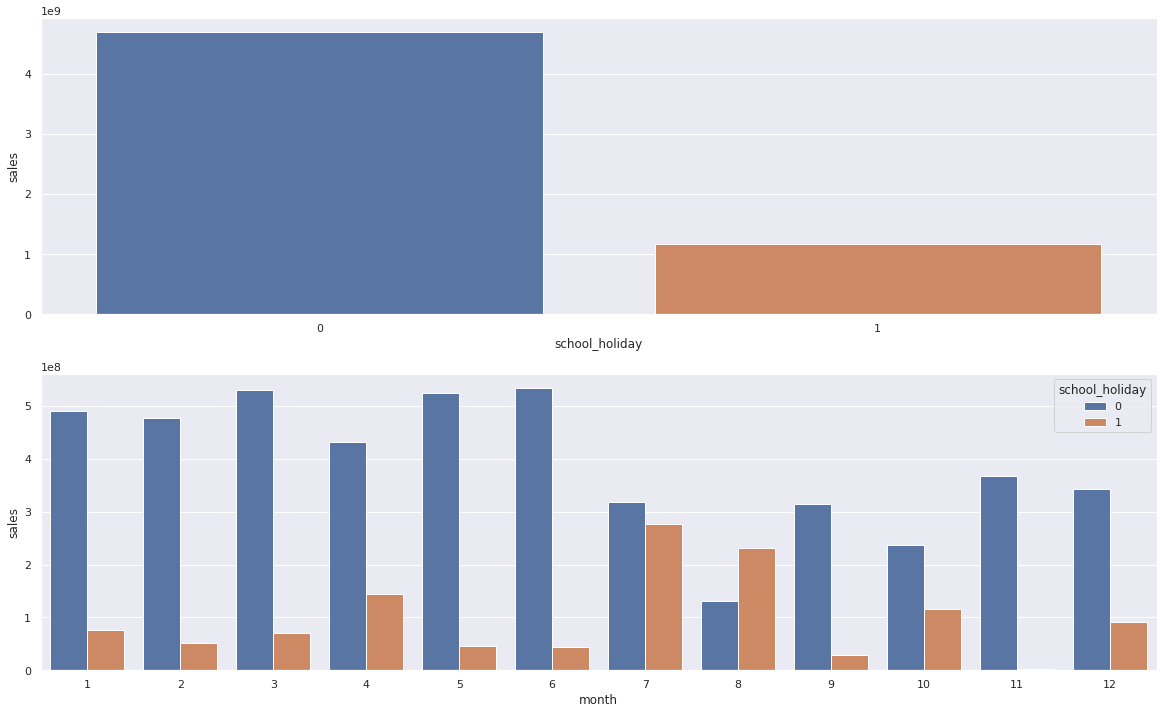

In [45]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

plt.show()

### Hypothesis Summary

In [46]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']
      ]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## Multivariate Analysis

### Numerical Attributes

<AxesSubplot:>

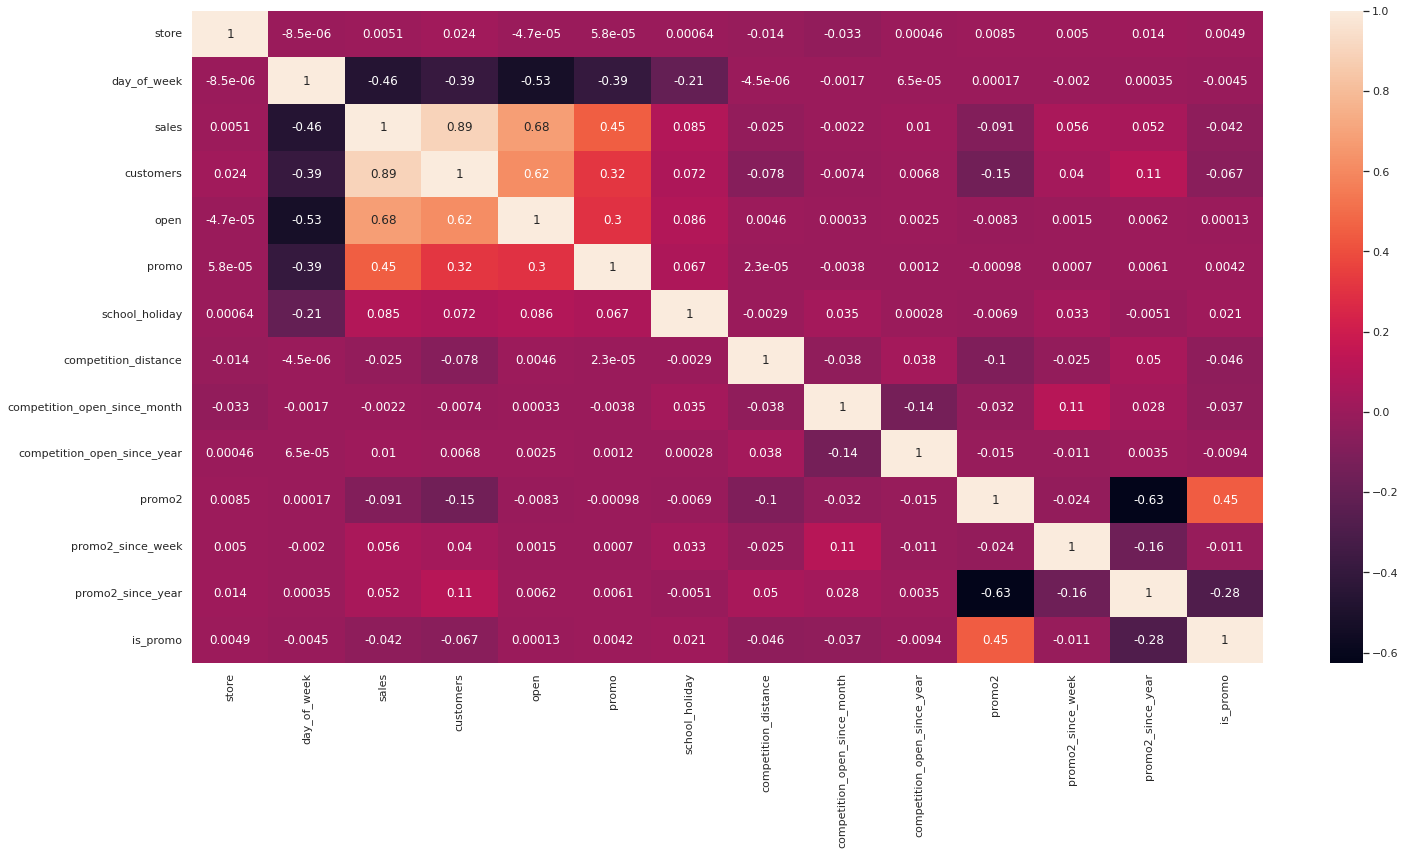

In [47]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(24,12))
sns.heatmap(correlation, annot=True)

### Categorical Attributes

To the categorical attributes we will use the Cramer's V method

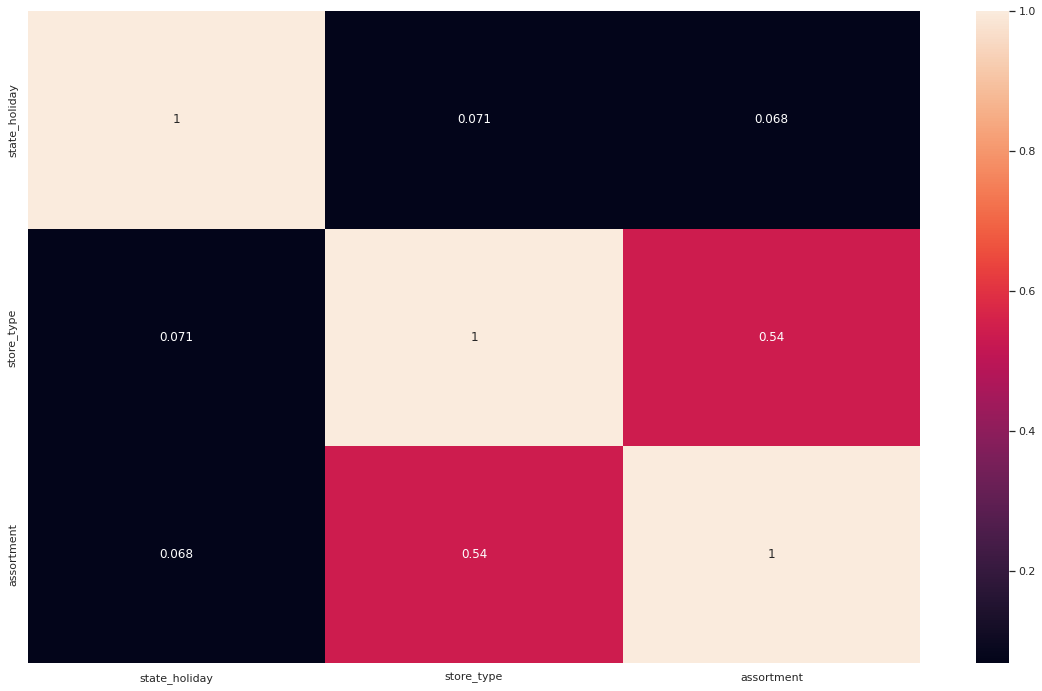

In [48]:
# categorical data only
a = df4.select_dtypes(include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


# final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
             })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)
plt.show()

# Data Preparation (Preprocessing)

In [65]:
df5 = df4.copy()

## Normalization:

Since we don't have any feature with normal distribution, we won't use normalization 

## Rescaling

### Min-Max Scaler


### Robust Scaler
  


In [66]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,day,month,year,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,31,7,2015,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,31,7,2015,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,31,7,2015,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,31,7,2015,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,31,7,2015,31,2015-30,2015-04-01,4,2015-07-27,0


In [67]:
df5.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'day', 'month',
       'year', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [68]:
# for those features who has significant outliers we will use robust scaler, to the others we will apply min-max scaler

# instanciate the class
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## Transformation

### Encoding

In [69]:
# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - label encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - ordinal encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation

In [70]:
df5['sales'] = np.log1p(df1['sales'])

### Nature Transformation
  - Cyclical Transformtation (eg: months of the year is cyclical)

In [71]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# Feature Selection

In [72]:
df6 = df5.copy()

## Split the Dataset into Train and Test

In [ ]:
# drop the features that derivated others
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [57]:
# since we have temporal data, we cannot randomly divide the dataset. In this case we will
# divide the last six weeks of sales for the test set and the rest for the training set

# calculate the last day of sales
df6[['date', 'store']].groupby('store').max().reset_index().head()

# calculate the last six weeks of sales
df6[['date', 'store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)


Timestamp('2015-06-19 00:00:00')

In [58]:
# split the dataset until the above date

# training set
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test set
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Min Training date: {}'.format(X_train['date'].min()))
print('Max Training date: {}'.format(X_train['date'].max()))

print('\nMin Test date: {}'.format(X_test['date'].min()))
print('Max Test date: {}'.format(X_test['date'].max()))

Min Training date: 2013-01-01 00:00:00
Max Training date: 2015-06-18 00:00:00

Min Test date: 2015-06-19 00:00:00
Max Test date: 2015-07-31 00:00:00


## Boruta Algorithm as Feature Selector

In [58]:
# # training and test dataset for boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # instanciate the RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # instanciate Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)



### Best Features from Boruta

In [59]:
# # select columns from boruta
# cols_selected = boruta.support_.tolist()


# # drop columns "date" and "sales" from the train dataset
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# # not selected cols by boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [60]:
# # the columns considered relevant by boruta
# cols_selected_boruta

In [61]:
# # the columns considered irrelevant by boruta
# cols_not_selected_boruta

The next step is compare the features we have considered relevant in the EDA step and the features boruta considered relevant.

Then we can decide which feature we will use considering the choice by boruta and the business knowledge we have.

A clue is to consider only the bouruta's choice in this first cycle of CRISP-DM and then insert the features we consider relevant and look to the accuracy is increasing.

## Manual Feature Selection

In [59]:
# save the boruta's result and insert the features "week_of_year_sin" and "month_sin"
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# add columns "date" and "sales"
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


In [60]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# Machine Learning Models



In [61]:
# select only the relevant features
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]


# time series data preparation
x_training = X_train[cols_selected_boruta_full] # relevant features + "date" and "sales"

## Average Model (baseline) 


In [65]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction - calculate the avg sell by store
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# merge the prediction with the original dataset
aux1 = pd.merge(aux1, aux2, how='left', on='store')

y_hat_baseline = aux1['predictions']

# performance
# the exponential is used to turn back the feature to the original format (it have been transformed using the log )
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(y_hat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression Model

In [ ]:
# model
lr = LinearRegression()

# training model
lr.fit(x_train, y_train)

# prediction
y_hat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_hat_lr) )
lr_result

**Note**: after those 2 models, we can see that the baseline model error is **smaller** than the linear model.

This could be a signal that the data is more complex and has not a linear behavior. So we can infer that linear models will not be a good predictor

### Linear Regression Model - Cross Validation

In [63]:
lr_result_cv = cross_validation(x_training, kfold=5, model_name='Linear Regression', model=lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized Model - Lasso

In [1]:
# model
lrr = Lasso(alpha=0.01)

# training model
lrr.fit(x_train, y_train)

# prediction
y_hat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(y_hat_lrr) )
lrr_result

NameError: name 'Lasso' is not defined

**Note**: Like with Linear Regression model, the same hapened with Lasso, which had a worse performance than baseline model

### Linear Regression Regularized - Lasso - Cross Validation

In [65]:
lrr_result_cv = cross_validation(x_training, kfold=5, model_name='Lasso', model=lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26



 ## Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# training model
rf.fit(x_train, y_train)

# prediction
y_hat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(y_hat_rf ))
rf_result

### Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, kfold=5, model_name='Random Forest Regressor', model=rf, verbose=True)
rf_result_cv


kfold number: 5

kfold number: 4

kfold number: 3

kfold number: 2

kfold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## XGBoost Regressor

In [67]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9)
# 
# training model
model_xgb.fit(x_train, y_train)

# prediction
y_hat_xgb = model_xgb.predict(x_test)
 
# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.705545,0.949492,7330.988585


### XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, kfold=5, model_name='XGBoost Regressor', model=model_xgb, verbose=True)
xgb_result_cv


kfold number: 5

kfold number: 4

kfold number: 3

kfold number: 2

kfold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


## Models Performance Comparation

### Single Performance



In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,890.527565,0.129193,1306.496922
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


### Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Note: Although the best result is from Random Forest Regressor, we will choose to put the XGBoost Regressor model into production, for reasons of education and knowledge

# Hyperparameter Fine Tuning


## Random Search

In [16]:
# # create a dictionary with the parameters and a list of some random values note: we will create a sparse list, to avoid create a big list

# param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#          'eta': [0.01, 0.03],
#          'max_depth': [3, 5 , 9],
#          'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytree': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15],
#          }

# # constant to determine the number of iterations
# max_eval = 5

In [ ]:
# # create a empty dataframe to populate it
# final_result = pd.DataFrame()

# # create a loop to choose randomly the parameters
# for i in range(max_eval):
#   # choose the parameters values randomly
#   hp = {k: random.sample(v, 1)[0] for k, v in param.item()}
#   prin(hp)

#   # model
#   model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                               n_estimators=hp['n_estimators'],
#                               eta=hp['eta'],
#                               max_depth=hp['max_depth'],
#                               subsample=hp['subsample'],
#                               colsample_bytree=hp['colsample_bytree'],
#                               min_child_weight=hp['min_child_weight'])
  
#   # performance
#   result = cross_validation(x_training, kfold=5, model_name='XGBoost Regressor', model=model_xgb, verbose=False)
  
#   # concatenate the results
#   final_result = pd.concat([final_result, result])

# final_result

In [ ]:
# final result

## Final Model

In [62]:
# this model has the best parameters according to random search
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'min_child_weight': 3
         }

In [63]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'])


# training model
model_xgb_tuned.fit(x_train, y_train)


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:store_type, assortment

In [71]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.01759492443152097

# Interpretation Error

In [79]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/tmp/ipykernel_15945/4169232537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
/tmp/ipykernel_15945/4169232537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## Business Performance

In [90]:
# sum of predictions
df9_sum = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_mae = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index()
df9_mae.rename(columns={0:'MAE'}, inplace=True)

df9_mape = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])). reset_index()
df9_mape.rename( columns={0:'MAPE'}, inplace=True)


# Merge
df9_aux1 = pd.merge(df9_mae, df9_mape, how='inner', on='store')
df9_aux2 = pd.merge(df9_sum, df9_aux1, how='inner', on='store')


# Scenarios
df9_aux2['worst_scenario'] = df9_aux2['predictions'] - df9_aux2['MAE']
df9_aux2['best_scenario'] = df9_aux2['predictions'] + df9_aux2['MAE']

# order columns
df9_aux2 = df9_aux2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [91]:
df9_aux2.sort_values('MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108359.789062,104977.608630,111741.969495,3382.180433,0.602768
908,909,220300.078125,212395.141071,228205.015179,7904.937054,0.518675
875,876,194060.812500,189924.534732,198197.090268,4136.277768,0.337730
169,170,201541.687500,200194.421637,202888.953363,1347.265863,0.332923
748,749,206800.953125,205789.192013,207812.714237,1011.761112,0.283049


Note: Here we can see that have some stores with high MAPE which means a high risk to implement this model on these stores.

## Total Performance

In [98]:
total_performance = df9_aux2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index()
total_performance.rename(columns={'index': 'Scenario', 0: 'Values'}, inplace=True)

total_performance['Values'] = total_performance['Values'].map('R$ {:,.2f}'.format)
total_performance

,Scenario,Values
0,predictions,"R$ 286,435,616.00"
1,worst_scenario,"R$ 285,579,535.55"
2,best_scenario,"R$ 287,291,675.73"


## Machine Learning Performance

In [99]:
# create columns "error" and "error rate"
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_15945/2379649040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_15945/2379649040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


In [101]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions,error,error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5736.361328,-473.361328,1.089941
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,5914.195312,149.804688,0.975296
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,9394.951172,-1080.951172,1.130016
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,11596.350586,2398.649414,0.828607
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,6324.432129,-1502.432129,1.311579


/home/menon/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/menon/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

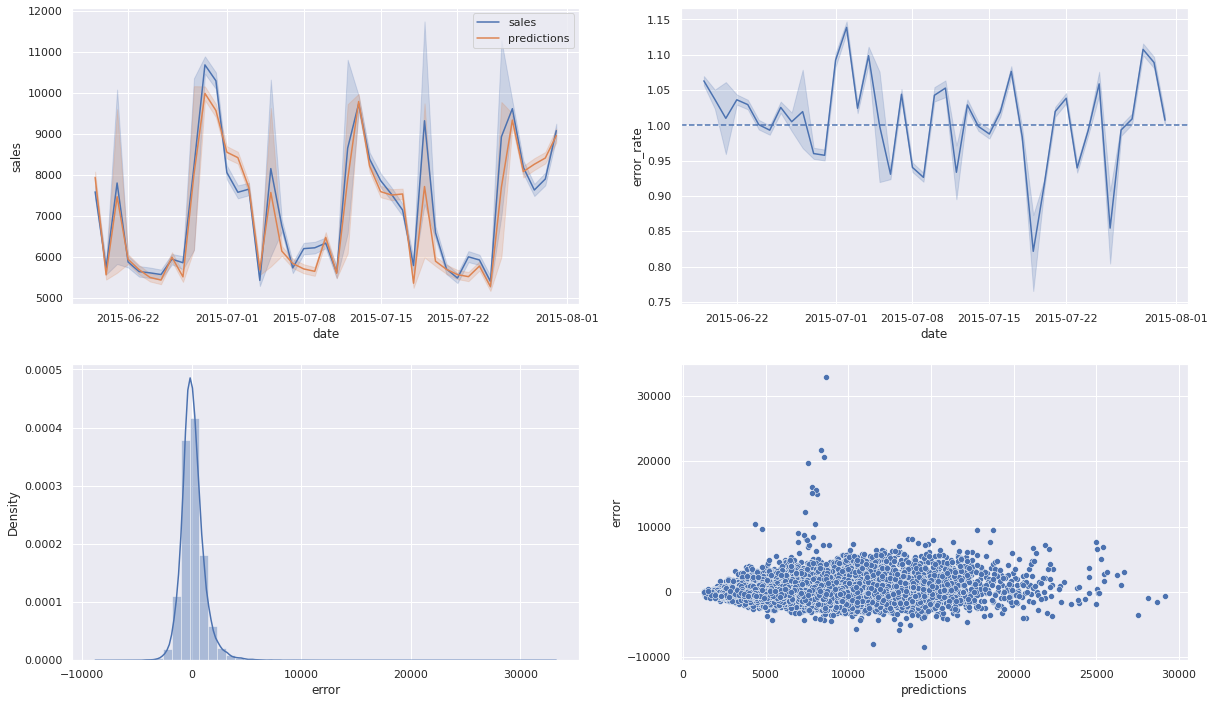

In [105]:
# sales and predictions by date
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='sales')
sns.lineplot(x='date', y='predictions', data=df9, label='predictions')

# error rate x date
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

# error distribution
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

#  
plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# Deploy Model to Production

In [107]:
# save trained model
pickle.dump(model_xgb_tuned, open('/home/menon/Documentos/repos/Rossmann-Sales-Prediction/model/model_rossmann.pkl', 'wb'))

## Rossmann Class

In [41]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/menon/Documentos/repos/Rossmann-Sales-Prediction/'
        self.competition_distance_scaler = pickle.load( open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load( open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load( open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        

    def data_cleaning(self, df1):
        
        ## Rename Columns
        old_cols = old_cols = ['Store',
                               'DayOfWeek',
                               'Date',
                               'Open',
                               'Promo',
                               'StateHoliday',
                               'SchoolHoliday',
                               'StoreType',
                               'Assortment',
                               'CompetitionDistance',
                               'CompetitionOpenSinceMonth',
                               'CompetitionOpenSinceYear',
                               'Promo2',
                               'Promo2SinceWeek',
                               'Promo2SinceYear',
                               'PromoInterval']
        
        new_cols = list(map(lambda x: inflection.underscore(x), old_cols))
        df1.columns = new_cols
        
        ## Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        df1.dtypes

        ## Fillout NA
        
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'] .apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:
                                                                    0 if x['promo_interval'] == 0 else
                                                                    1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        
        ## Change Types

        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1


    def feature_engineering( self, df2):

        # day
        df2['day'] = df2['date'].dt.day

        # month
        df2['month'] = df2['date'].dt.month

        # year
        df2['year'] = df2['date'].dt.year

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                         month=x['competition_open_since_month'],
                                                                         day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(
            str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
            x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                    'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                         'easter_holiday' if x == 'b' else
                                                         'christmas' if x == 'c' else 'regular_day')

        # Variable Filtering
        ## Rows Filtering
        df2 = df2[df2['open'] != 0]

        ## Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    

    
    def data_preparation( self, df5 ):
        


        ## Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        

                
        ## Transformation
        ### Encoding

        # state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - label encoder
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])

        #assortment - ordinal encoder
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        
        ### Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos']

        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## API Handler

In [56]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/menon/Documentos/repos/Rossmann-Sales-Prediction/model/model_rossmann.pkl', 'rb'))


# initialize API
app = Flask(__name__)

# endpoint
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    
    if test_json: # exist data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: #multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        # instantiante Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:# don't exist data
        return Response('{}', status=200, mimetype='aplication/json')
    

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## API Tester

In [33]:
import requests

In [98]:
# load test dataset
df10 = pd.read_csv('/home/menon/Documentos/repos/Rossmann-Sales-Prediction/data/test.csv')

In [99]:
# merge test with store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')


# choose one store to make a prediction
df_test = df_test[df_test['Store'].isin([12, 22, 24, 26, 45, 77, 46])]

# remove days where store is closed
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

# remove the "Id" column
df_test = df_test.drop('Id', axis=1)


In [100]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [101]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-sales-prediction-app.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [102]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,day,month,year,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,17,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,7875.956055
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,17,9,2015,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4835.247070
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,17,9,2015,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,9598.488281
3,45,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,9710.0,2,2014,0,38,2015,0,Sep,0,17,9,2015,38,2015-37,2014-02-01T00:00:00.000Z,19,2015-09-14T00:00:00.000Z,0,5448.364746
4,46,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,basic,1200.0,9,2005,1,14,2011,"Jan,Apr,Jul,Oct",Sep,0,17,9,2015,38,2015-37,2005-09-01T00:00:00.000Z,122,2011-03-28T00:00:00.000Z,233,5520.966797


In [84]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()


for i in range(len(d2)):
    print('Store number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],
                                                                            d2.loc[i, 'prediction']))
    

Store number 12 will sell R$ 305,636.13 in the next 6 weeks
Store number 22 will sell R$ 182,857.77 in the next 6 weeks
Store number 24 will sell R$ 370,106.29 in the next 6 weeks
Store number 45 will sell R$ 215,838.86 in the next 6 weeks
Store number 46 will sell R$ 206,972.59 in the next 6 weeks
Store number 77 will sell R$ 305,457.95 in the next 6 weeks
